In [56]:
# Do the following in Python Notebook using ib-insyc package:
# Find two stocks in Dow Index, and daily price history for two years: 2/2/2019 - 2/1/2021.
# Show histogram, volatility and their correlation
# Discuss to what extend the price history either support or invalidate the GBM assumptions for stock movements

In [52]:
from ib_insync import*
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
# from statsmodels import regression, stats
import math
import datetime
import statsmodels.formula.api as smf
#from datetime import date, time, datetime, timedelta
import seaborn as sns

In [2]:
# Connect to IB Server
ib=IB()
util.startLoop()
ib.connect('127.0.0.1',7497, clientId= 565)

<IB connected to 127.0.0.1:7497 clientId=565>

In [3]:
# find a stock contract and fully qualify it with all the attributes
ticker1 = 'GS' # The Goldman Sachs Group, Inc.
ticker2 = 'JPM' # JPMorgan Chase & Co.
contract1 = Contract(symbol = ticker1, secType = 'STK', exchange = 'SMART', currency = 'USD')
ib.qualifyContracts(contract1)
contract2 = Contract(symbol = ticker2, secType = 'STK', exchange = 'SMART', currency = 'USD')
ib.qualifyContracts(contract2)

[Contract(secType='STK', conId=1520593, symbol='JPM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='JPM', tradingClass='JPM')]

In [18]:
# Grab price and volume data from IB
# These are called bar data: each rows corresponds to a bar of price range within a given time interval.
bar1 = ib.reqHistoricalData(
    contract1,
    endDateTime = datetime.date(2021,2,1),
    durationStr='2 Y',
    barSizeSetting = '1 day',
    whatToShow = 'Trades',
    useRTH = True,
    formatDate = 1
)
# Convert the bar data into dataframe
df1 = util.df(bar1) # Last trade
df1

,date,open,high,low,close,volume,average,barCount
0,2019-02-04,195.91,197.76,194.78,197.72,16278,196.3860,11289
1,2019-02-05,198.12,199.33,196.86,198.01,17296,197.9855,11496
2,2019-02-06,197.18,199.06,195.83,196.62,13403,197.0305,9393
3,2019-02-07,195.42,195.88,191.05,193.07,19737,192.8145,14038
4,2019-02-08,191.72,192.62,188.21,191.67,19178,190.4045,13505
5,2019-02-11,192.88,193.32,191.07,191.33,12639,191.8220,9234
6,2019-02-12,193.05,195.65,193.00,194.49,16356,194.6505,11300
7,2019-02-13,195.92,198.78,194.61,194.69,18239,196.7530,12274
8,2019-02-14,192.21,194.13,189.44,192.53,20392,192.3735,13477
9,2019-02-15,193.21,198.89,193.10,198.50,22075,197.3615,14678


In [19]:
bar2 = ib.reqHistoricalData(
    contract2,
    endDateTime = datetime.date(2021,2,1),
    durationStr='2 Y',
    barSizeSetting = '1 day',
    whatToShow = 'Trades',
    useRTH = True,
    formatDate = 1
)
# Convert the bar data into dataframe
df2 = util.df(bar2) # Last trade
df2.head()

,date,open,high,low,close,volume,average,barCount
0,2019-02-04,103.79,104.25,103.01,104.25,73028,103.6705,41884
1,2019-02-05,104.52,104.55,103.29,103.79,91311,103.7695,47798
2,2019-02-06,103.71,104.62,103.46,103.74,62898,103.7985,37925
3,2019-02-07,103.25,103.50,101.44,102.38,100847,102.1370,58478
4,2019-02-08,102.08,102.34,100.06,101.36,93137,100.9695,53660


In [23]:
# Compute log return and percentage return
df1['log'] = df1['close'].apply(lambda x: math.log(x))
df1['pct'] = df1['close'].pct_change()
df1['log_diff'] = df1['log'].diff()
df1['log_diff'].head()

0         NaN
1    0.001466
2   -0.007045
3   -0.018220
4   -0.007278
Name: log_diff, dtype: float64

Log return volatility is: 0.02542151421163967 skew is: -0.21451347061783183 kurtosis is: 9.465532126079438


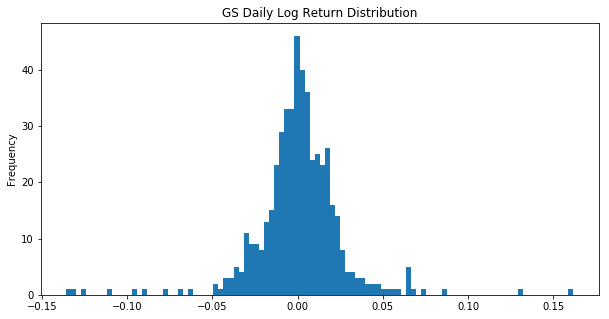

In [28]:
# Histogram and risk statistics
# Log return
df1['log_diff'].plot.hist(figsize = [10, 5], bins = 100, title = str(ticker1) + ' Daily Log Return Distribution')
print('Log return volatility is:', df1['log_diff'].std(), 'skew is:', df1['log_diff'].skew(), 'kurtosis is:', df1['log_diff'].kurtosis())                         

Log return volatility is: 0.02542636693299634 skew is: 0.2243868560284524 kurtosis is: 9.970156246348393


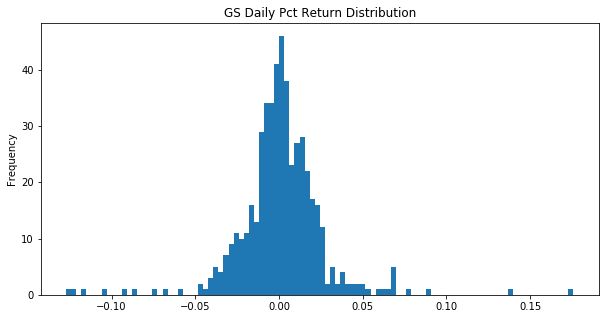

In [30]:
# Pct return
df1['pct'].plot.hist(figsize = [10, 5], bins = 100, title = str(ticker1) + ' Daily Pct Return Distribution')
print('Log return volatility is:', df1['pct'].std(), 'skew is:', df1['pct'].skew(), 'kurtosis is:', df1['pct'].kurtosis())

Log return volatility is: 0.025783444925088977 skew is: -0.06059848227186529 kurtosis is: 10.859241194817642


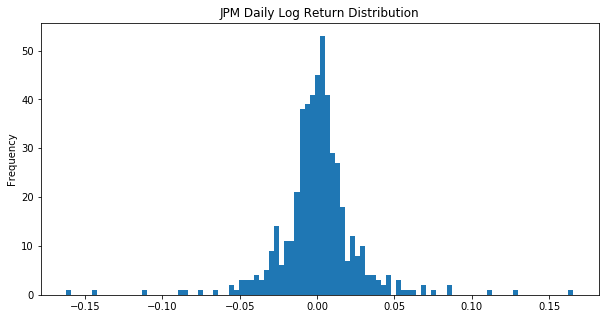

In [31]:
# Compute log return and percentage return
df2['log'] = df2['close'].apply(lambda x: math.log(x))
df2['pct'] = df2['close'].pct_change()
df2['log_diff'] = df2['log'].diff()
# Histogram and risk statistics
# Log return
df2['log_diff'].plot.hist(figsize = [10, 5], bins = 100, title = str(ticker2) + ' Daily Log Return Distribution')
print('Log return volatility is:', df2['log_diff'].std(), 'skew is:', df2['log_diff'].skew(), 'kurtosis is:', df2['log_diff'].kurtosis())                         

Log return volatility is: 0.025840941192086055 skew is: 0.43249603302101913 kurtosis is: 11.116182743673287


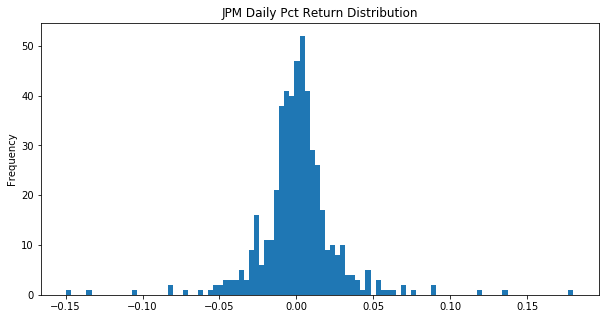

In [32]:
# Pct return
df2['pct'].plot.hist(figsize = [10, 5], bins = 100, title = str(ticker2) + ' Daily Pct Return Distribution')
print('Log return volatility is:', df2['pct'].std(), 'skew is:', df2['pct'].skew(), 'kurtosis is:', df2['pct'].kurtosis())

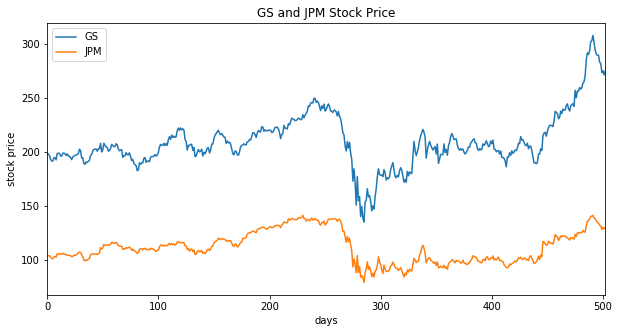

The stock price correlation is: 0.8033488636906703


In [49]:
# Before running the program, I guess the two stocks are positively correlated since they are both financial service companies.

df1['close'].plot(figsize=(10, 5), label = 'GS')
df2['close'].plot(label = 'JPM')
plt.title("GS and JPM Stock Price")
plt.ylabel('stock price')
plt.xlabel('days')
plt.legend()
plt.show()
print("The stock price correlation is:", df1['close'].corr(df2['close']))

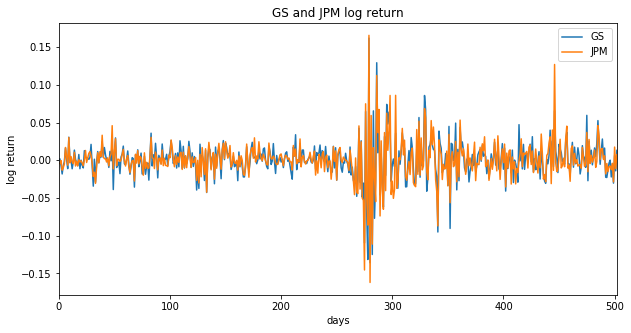

The log return correlation is: 0.8829285194822747


In [50]:
df1['log_diff'].plot(figsize=(10, 5), label = 'GS')
df2['log_diff'].plot(label = 'JPM')
plt.title("GS and JPM log return")
plt.ylabel('log return')
plt.xlabel('days')
plt.legend()
plt.show()
print("The log return correlation is:", df1['log_diff'].corr(df2['log_diff']))

In [54]:
# Normality Test
# GS
k2, p = stats.normaltest(df1['log_diff'], nan_policy = 'omit')
alpha = 0.001
print(k2, p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

99.99087384710488 1.9375709914385028e-22
The null hypothesis can be rejected


In [55]:
# JPM
k2, p = stats.normaltest(df2['log_diff'], nan_policy = 'omit')
alpha = 0.001
print(k2, p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

104.25596782220218 2.2966998110315102e-23
The null hypothesis can be rejected
